TODO:
    - Remove irrelevant cells
    - Fix warnings
    - Pretty up relevant plots
    - Add/improve textual descriptions/markdown
    - Triangulate returner position, linear reg prediction, nn prediction. Use stdev of actual ball landing positions to draw heat map from center point
    - More features(?) - punt rush, wind, time to kick from snap
    - Standardize punt directional data(?)

In [220]:
%matplotlib notebook

In [221]:
from types import SimpleNamespace

import matplotlib.animation as anm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

COLUMN = SimpleNamespace(**{
    'PLAY_TYPE': 'specialTeamsPlayType',
    'SPECIAL_TEAMS_RESULT': 'specialTeamsResult',
    'PLAY_RESULT': 'playResult', # Net difference in field position
    'POSITION': 'position',
    'PLAY_EVENT': 'event',
    'GAME_ID': 'gameId',
    'PLAY_ID': 'playId',
    'GUNNERS': 'gunners',
    'GUNNER_LIST': 'gunnerList',
    'HOME_TEAM': 'homeTeamAbbr',
    'VISITOR_TEAM': 'visitorTeamAbbr',
    'IS_GUNNER': 'isGunner',
    'JERSEY_NUMBER': 'jerseyNumber',
    'TEAM': 'team',
    'POSSESSION_TEAM': 'possessionTeam',
    'TIME': 'time',
    'NFL_ID': 'nflId',
    'RETURNER_ID': 'returnerId',
    'PRIMARY_RETURNER_ID': 'primaryReturnerId',
    'PLAYER_TEAM_ID': 'playerTeamId',
    'X': 'x',
    'Y': 'y',
    'COLOR': 'color',
    'FRAME': 'frame',
    'DISPLAY_NAME': 'displayName',
    'KICK_RETURN_YARDAGE': 'kickReturnYardage',
    'DISTANCE_FROM_SIDELINE': 'distanceFromSideline',
    'SORT_POSITION': 'sortPosition',
})

POSITION = SimpleNamespace(**{
    'KICKER': 'K',
    'PUNTER': 'P',
    'LONG_SNAPPER': 'LS',
})

PLAY_TYPE = SimpleNamespace(**{
    'FIELD_GOAL': 'Field Goal',
    'PUNT': 'Punt',
})

PLAY_EVENT = SimpleNamespace(**{
    'BALL_SNAP': 'ball_snap',
    'FG_ATTEMPT': 'field_goal_attempt',
    'PUNT': 'punt',
    'PUNT_RECEIVED': 'punt_received',
    'OUT_OF_BOUNDS': 'out_of_bounds',
    'PUNT_LAND': 'punt_land',
    'FAIR_CATCH': 'fair_catch',
    'PUNT_MUFFED': 'punt_muffed',
})

SPECIAL_TEAMS_RESULT = SimpleNamespace(**{
    'BLOCKED': 'Blocked Kick Attempt',
    'DOWNED': 'Downed',
    'KICK_GOOD': 'Kick Attempt Good',
    'KICK_NO_GOOD': 'Kick Attempt No Good',
    'RETURN': 'Return',
    'TOUCHBACK': 'Touchback',
    'FAIR_CATCH': 'Fair Catch',
    'MUFFED': 'Muffed',
    'OUT_OF_BOUNDS': 'Out of Bounds',
})

TEAM = SimpleNamespace(**{
    'HOME': 'home',
    'AWAY': 'away',
    'FOOTBALL': 'football',
})

In [222]:
games_df = pd.read_csv('input/games.csv')
players_df = pd.read_csv('input/players.csv')
plays_df = pd.read_csv('input/plays.csv')
pff_scouting_df = pd.read_csv('input/PFFScoutingData.csv')
tracking_2018_df = pd.read_csv('input/tracking2018.csv')
tracking_2019_df = pd.read_csv('input/tracking2019.csv')
tracking_2020_df = pd.read_csv('input/tracking2020.csv')
tracking_df = pd.concat([tracking_2018_df, tracking_2019_df, tracking_2020_df], ignore_index=True)
game_plays_df = pd.merge(games_df, plays_df, left_on=COLUMN.GAME_ID, right_on=COLUMN.GAME_ID)

In [223]:
game_plays_df = game_plays_df.dropna(subset=[COLUMN.RETURNER_ID])

def getPrimaryReturnerId(value):
    returners = str(value).split(';')
    return int(returners[0])

game_plays_df[COLUMN.PRIMARY_RETURNER_ID] = game_plays_df[COLUMN.RETURNER_ID] \
    .apply(getPrimaryReturnerId) \
    .astype('Int64')

tracking_df[COLUMN.TIME] = pd.to_datetime(tracking_df[COLUMN.TIME])
tracking_df[COLUMN.JERSEY_NUMBER] = tracking_df[COLUMN.JERSEY_NUMBER].astype('Int64')
tracking_df[COLUMN.NFL_ID] = tracking_df[COLUMN.NFL_ID].astype('Int64')

In [224]:
punt_tracking_df = pd.merge(
    pff_scouting_df,
    tracking_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)
punt_plays_df = game_plays_df[game_plays_df[COLUMN.PLAY_TYPE] == PLAY_TYPE.PUNT]
punt_tracking_df = pd.merge(
    punt_tracking_df,
    punt_plays_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

In [225]:
conditions = [
    (punt_tracking_df[COLUMN.TEAM] == TEAM.HOME),
    (punt_tracking_df[COLUMN.TEAM] == TEAM.AWAY),
]

values = [
    punt_tracking_df[COLUMN.HOME_TEAM] + ' ' + punt_tracking_df[COLUMN.JERSEY_NUMBER].astype(str),
    punt_tracking_df[COLUMN.VISITOR_TEAM] + ' ' + punt_tracking_df[COLUMN.JERSEY_NUMBER].astype(str),
]

punt_tracking_df[COLUMN.PLAYER_TEAM_ID] = np.select(conditions, values)

def splitGunners(value):
    if value is None:
        return []
    gunners = str(value).split(';')
    return [gunner.strip() for gunner in gunners]

punt_tracking_df[COLUMN.GUNNER_LIST] = punt_tracking_df[COLUMN.GUNNERS].apply(splitGunners)

punt_tracking_df[COLUMN.IS_GUNNER] = punt_tracking_df.apply(
    lambda x: str(x[COLUMN.PLAYER_TEAM_ID]) in x[COLUMN.GUNNER_LIST],
    axis=1,
)

<IPython.core.display.Javascript object>


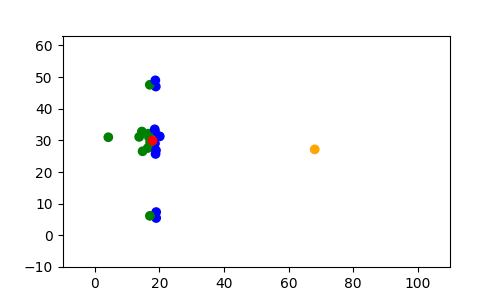

In [226]:
punt_tracking_df.loc[:, COLUMN.FRAME] = punt_tracking_df[[COLUMN.GAME_ID, COLUMN.TIME]] \
    .apply(tuple, axis=1) \
    .rank(ascending=True, method='dense')

is_returner = np.where(punt_tracking_df[COLUMN.PRIMARY_RETURNER_ID].fillna(-1) == punt_tracking_df[COLUMN.NFL_ID].fillna(-2), True, False)

conditions = [
#     punt_tracking_df[COLUMN.IS_GUNNER],
    is_returner,
    punt_tracking_df[COLUMN.TEAM] == TEAM.HOME,
    punt_tracking_df[COLUMN.TEAM] == TEAM.AWAY,
    punt_tracking_df[COLUMN.TEAM] == TEAM.FOOTBALL,
]
values = [
    'orange',
    'green',
    'blue',
    'red',
]
punt_tracking_df.loc[:, COLUMN.COLOR] = np.select(conditions, values)

fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
first_frame = punt_tracking_df[punt_tracking_df[COLUMN.FRAME] == 1]
c = first_frame[COLUMN.COLOR]
x = first_frame[COLUMN.X]
y = first_frame[COLUMN.Y]
scatter = ax.scatter(x, y, c=c)

def animate(i):
    filtered = punt_tracking_df[punt_tracking_df[COLUMN.FRAME] == i+1]
    c = filtered[COLUMN.COLOR]
    x = filtered[COLUMN.X]
    y = filtered[COLUMN.Y]
    data = np.c_[x, y]
    scatter.set_offsets(data)
    scatter.set_color(c)

animation = anm.FuncAnimation(
    fig,
    animate,
    interval=10,
    frames=int(punt_tracking_df[COLUMN.FRAME].max()),
    repeat=True,
)
plt.show()

In [227]:
# Punt distance from sideline vs return distance
punt_tracking_df['sidelineA'] = 53.3 - punt_tracking_df[COLUMN.Y]
punt_tracking_df['sidelineB'] = punt_tracking_df[COLUMN.Y]
punt_tracking_df[COLUMN.DISTANCE_FROM_SIDELINE] = punt_tracking_df[['sidelineA', 'sidelineB']].min(axis=1)

<IPython.core.display.Javascript object>


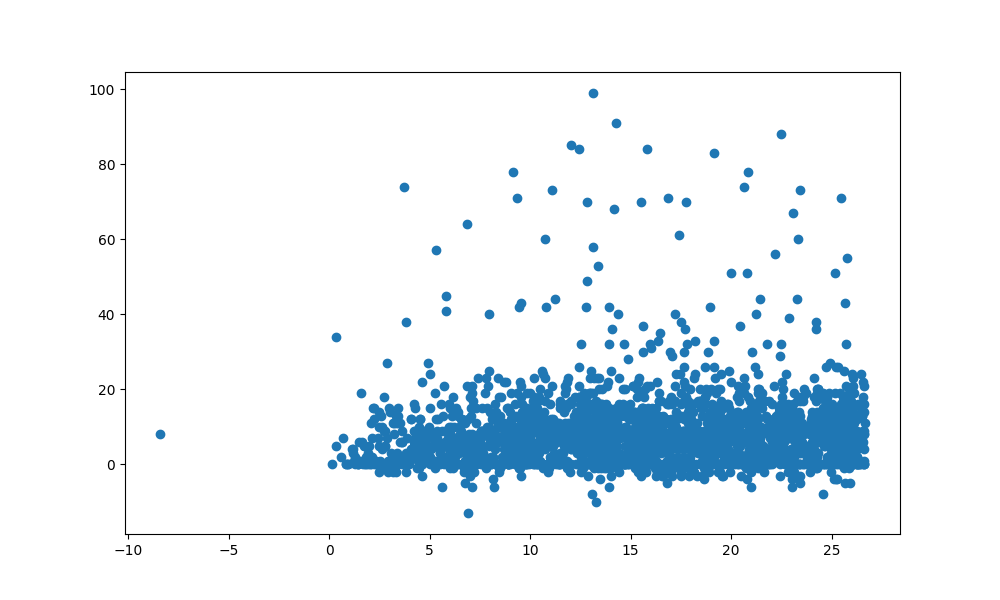

In [228]:
punt_received_football_only_df = punt_tracking_df[
    (punt_tracking_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.PUNT_RECEIVED)
    & (punt_tracking_df[COLUMN.TEAM] == 'football')
]
x = punt_received_football_only_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [229]:
x.corr(y)

0.05082782297377636

In [230]:
punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()

8.710697271546124

In [231]:
punt_received_football_only_df['aboveAverageReturn'] = \
    punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE] > punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()
punt_received_football_only_df[
    [COLUMN.X, COLUMN.Y, COLUMN.DISTANCE_FROM_SIDELINE, COLUMN.KICK_RETURN_YARDAGE, 'aboveAverageReturn']
].head()

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_3422/3108297030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  punt_received_football_only_df['aboveAverageReturn'] = \


,x,y,distanceFromSideline,kickReturnYardage,aboveAverageReturn
2893,72.61,39.18,14.12,5.0,False
7911,91.77,35.94,17.36,8.0,False
12720,82.02,42.04,11.26,9.0,True
19308,30.37,32.33,20.97,12.0,True
22523,36.61,44.87,8.43,-1.0,False


<IPython.core.display.Javascript object>


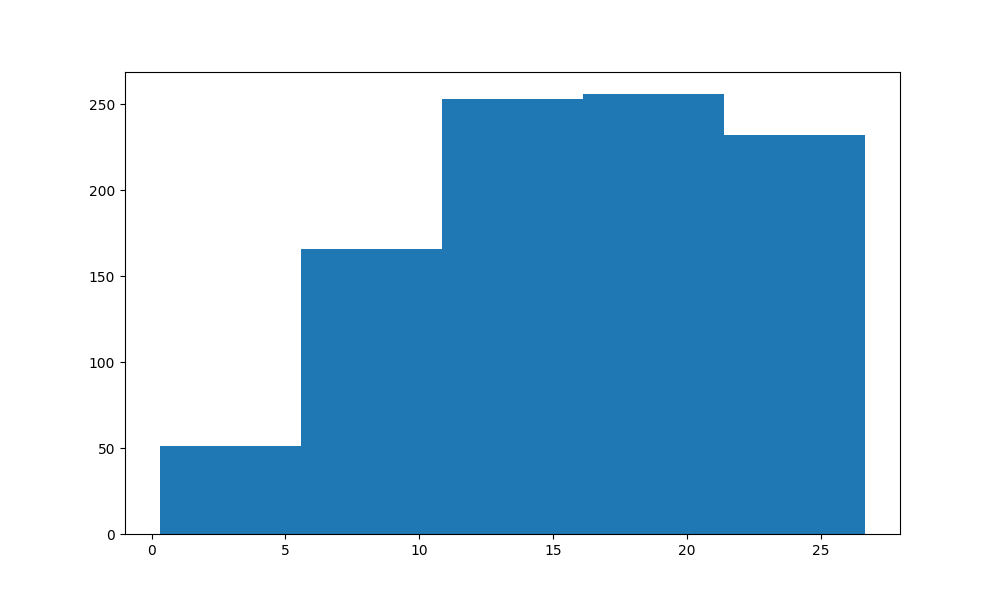

In [232]:
above_average_returns_df = punt_received_football_only_df[punt_received_football_only_df['aboveAverageReturn'] == True]
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
bins = 5
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x=x, bins=bins)
plt.show()

In [233]:
above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE].corr(above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE])

0.005363609793819777

<IPython.core.display.Javascript object>


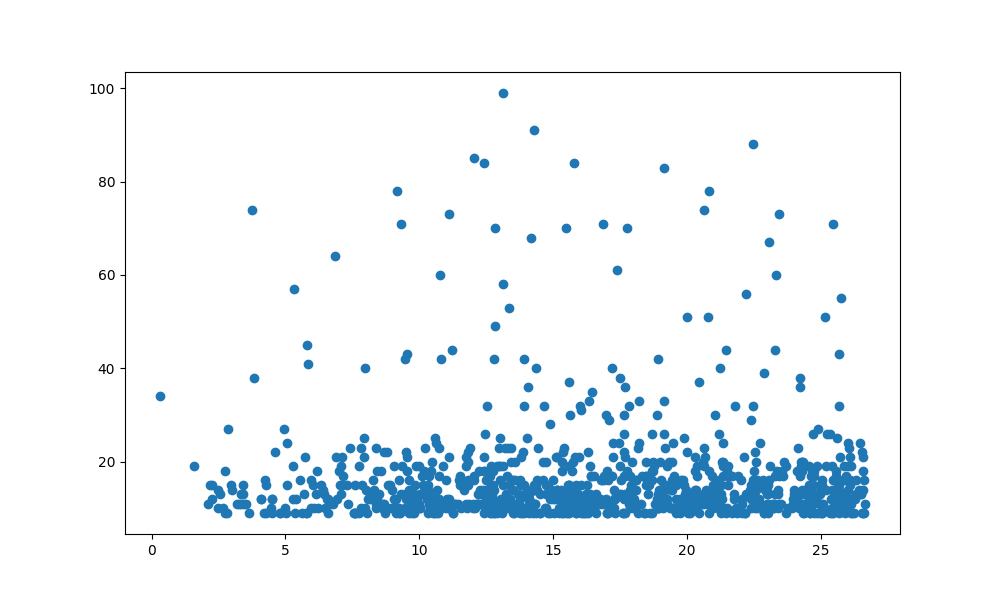

In [272]:
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [235]:
'''
Predict punt landing position based on pre-snap inputs (e.g. ball position)

Inputs:
  - Positions of all players and ball at time of snap (22 players + ball, x and y positions)
Outputs:
  - Ball landing position x, y
  
TODO:
  - Stack all 3 years of data
  - For inputs, filter tracking data to play event = ball_snap and special teams result
       is one of Return', 'Touchback', 'Fair Catch', 'Downed', 'Muffed', 'Out of Bounds'
  - For outputs, filter to football position when special teams result is one of Return', 'Touchback',
       'Fair Catch', 'Downed', 'Muffed', 'Out of Bounds'
       AND play event is one of punt_received, punt_land,
       fair_catch, punt_muffed
       AND team is football
  - Partition/sync inputs and outputs based on game id and play id
  - Partition data into training data and test data (80/20)
  - Use sklearn.linear_model.LinearRegression to train and test
  - Visualize results
  
A, B, C, D, E, F

A * x0 + B * x1 + C * x2 + D * x3 ... = ball landing position

                      SORT
x0 = ball x           1
x1 = ball y           2
x2 = punter x
x3 = punter y
x4 = returner x
x5 = returner y
x6 = player3 x
x7 = player3 y
etc...

y0 = ball landing x
y1 = ball landing y

football filter COLUMN.TEAM == 'football'
punter filter COLUMN.POSITION == 'P'
returner filter returnerId == nflId 
'''
special_teams_results = [
    SPECIAL_TEAMS_RESULT.RETURN,
    SPECIAL_TEAMS_RESULT.TOUCHBACK,
    SPECIAL_TEAMS_RESULT.FAIR_CATCH,
    SPECIAL_TEAMS_RESULT.DOWNED,
    SPECIAL_TEAMS_RESULT.MUFFED,
    SPECIAL_TEAMS_RESULT.OUT_OF_BOUNDS,
]
ball_land_events = [
    PLAY_EVENT.PUNT_RECEIVED,
    PLAY_EVENT.PUNT_LAND,
    PLAY_EVENT.FAIR_CATCH,
    PLAY_EVENT.PUNT_MUFFED,
]
punt_predict_df = punt_tracking_df[
    punt_tracking_df[COLUMN.SPECIAL_TEAMS_RESULT].isin(special_teams_results)
]

In [236]:
is_football = punt_predict_df[COLUMN.TEAM] == TEAM.FOOTBALL
is_punter = punt_predict_df[COLUMN.POSITION] == POSITION.PUNTER
is_returner = (~np.isnan(punt_predict_df[COLUMN.PRIMARY_RETURNER_ID])) \
    & (~np.isnan(punt_predict_df[COLUMN.NFL_ID])) \
    & (punt_predict_df[COLUMN.PRIMARY_RETURNER_ID] == punt_predict_df[COLUMN.NFL_ID])
inputs_df = punt_predict_df[
    (punt_predict_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.BALL_SNAP)
    # & ((is_football) | (is_punter) | (is_returner))
    # & (punt_predict_df[COLUMN.RETURNER_ID].str.contains(';') == False) # filter out multiple returner scenarios
]

conditions = [
    (inputs_df[COLUMN.TEAM] == TEAM.FOOTBALL),
    (inputs_df[COLUMN.POSITION] == POSITION.PUNTER),
    np.where(inputs_df[COLUMN.PRIMARY_RETURNER_ID].fillna(-1) == inputs_df[COLUMN.NFL_ID].fillna(-2), True, False),
]
values = [1, 2, 3]
inputs_df[COLUMN.SORT_POSITION] = np.select(conditions, values)

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_3422/3143725473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_df[COLUMN.SORT_POSITION] = np.select(conditions, values)


In [237]:
inputs_df['playerTeamAbbr'] = np.where(
    inputs_df[COLUMN.TEAM] == TEAM.HOME,
    inputs_df[COLUMN.HOME_TEAM],
    inputs_df[COLUMN.VISITOR_TEAM],
)
inputs_df['isPuntTeam'] = np.where(
    inputs_df['playerTeamAbbr'] == inputs_df[COLUMN.POSSESSION_TEAM],
    True,
    False,
)
inputs_df['puntTeamYPosition'] = inputs_df[['isPuntTeam', COLUMN.Y]].apply(tuple, axis=1)
inputs_df['remainingSortLocation'] = inputs_df.groupby([COLUMN.GAME_ID, COLUMN.PLAY_ID])['puntTeamYPosition'] \
    .rank(method='first')
inputs_df['remainingSortLocation'] = inputs_df['remainingSortLocation'] + 3
inputs_df['sortValue'] = np.where(
    inputs_df[COLUMN.SORT_POSITION] > 0,
    inputs_df[COLUMN.SORT_POSITION],
    inputs_df['remainingSortLocation'],
)

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_3422/1632605651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_df['playerTeamAbbr'] = np.where(
/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_3422/1632605651.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_df['isPuntTeam'] = np.where(
/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_3422/1632605651.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [238]:
inputs_df = inputs_df.sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'sortValue'])

aggs = { 'x': lambda x: x.to_list(), 'y': lambda y: y.to_list() }
inputs_df = inputs_df.groupby([COLUMN.GAME_ID, COLUMN.PLAY_ID]).agg(aggs).reset_index()
inputs_df = inputs_df[
    (inputs_df[COLUMN.X].map(len) == 23)
    & (inputs_df[COLUMN.Y].map(len) == 23)
]
# Filter out plays where returner is near line of scrimmage
inputs_df = inputs_df[
    np.abs(inputs_df[COLUMN.X].str[0] - inputs_df[COLUMN.X].str[2]) > 10
]

def merge_coordinates(df):
    merged = []
    for i in range(23):
        merged.append(df[COLUMN.X][i])
        merged.append(df[COLUMN.Y][i])
    return merged

inputs_df['features'] = inputs_df.apply(merge_coordinates, axis=1)
inputs_df.head()

,gameId,playId,x,y,features
0,2018090600,366,"[17.9, 4.2, 67.05, 19.0, 19.02, 18.71, 18.27, 18.65, 20.12, 18.54, 18.41, 18.91, 18.75, 17.06, 14.79, 16.39, 17.09, 17.49, 16.76, 13.76, 16.51, 14.56, 17.02]","[29.94, 31.01, 26.31, 5.47, 7.34, 25.62, 26.84, 29.03, 31.29, 33.06, 33.63, 47.03, 49.0, 6.16, 26.57, 27.64, 29.37, 29.97, 31.01, 31.14, 32.14, 32.83, 47.57]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31, 19.0, 5.47, 19.02, 7.34, 18.71, 25.62, 18.27, 26.84, 18.65, 29.03, 20.12, 31.29, 18.54, 33.06, 18.41, 33.63, 18.91, 47.03, 18.75, 49.0, 17.06, 6.16, 14.79, 26.57, 16.39, 27.64, 17.09, 29.37, 17.49, 29.97, 16.76, 31.01, 13.76, 31.14, 16.51, 32.14, 14.56, 32.83, 17.02, 47.57]"
1,2018090600,973,"[20.8, 7.04, 68.89, 21.77, 21.49, 21.25, 21.44, 21.46, 21.27, 20.68, 21.23, 21.06, 23.01, 19.74, 17.61, 19.36, 16.04, 19.68, 20.49, 19.37, 19.23, 17.67, 19.83]","[29.88, 29.32, 34.84, 6.36, 25.32, 26.11, 27.84, 29.31, 31.04, 31.9, 33.68, 35.38, 45.81, 5.97, 27.96, 28.08, 28.64, 28.74, 29.55, 30.71, 31.72, 31.84, 46.06]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84, 21.77, 6.36, 21.49, 25.32, 21.25, 26.11, 21.44, 27.84, 21.46, 29.31, 21.27, 31.04, 20.68, 31.9, 21.23, 33.68, 21.06, 35.38, 23.01, 45.81, 19.74, 5.97, 17.61, 27.96, 19.36, 28.08, 16.04, 28.64, 19.68, 28.74, 20.49, 29.55, 19.37, 30.71, 19.23, 31.72, 17.67, 31.84, 19.83, 46.06]"
2,2018090600,1989,"[35.82, 22.04, 85.21, 36.87, 36.87, 36.36, 36.34, 38.61, 36.44, 36.94, 36.61, 36.17, 37.2, 35.09, 32.44, 34.33, 30.72, 34.64, 35.47, 34.44, 34.45, 32.63, 34.99]","[23.79, 23.28, 28.81, 5.36, 7.23, 19.63, 21.12, 22.53, 22.53, 24.54, 26.34, 27.66, 42.59, 6.01, 21.67, 22.04, 22.42, 22.93, 23.74, 24.58, 25.44, 25.86, 43.26]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81, 36.87, 5.36, 36.87, 7.23, 36.36, 19.63, 36.34, 21.12, 38.61, 22.53, 36.44, 22.53, 36.94, 24.54, 36.61, 26.34, 36.17, 27.66, 37.2, 42.59, 35.09, 6.01, 32.44, 21.67, 34.33, 22.04, 30.72, 22.42, 34.64, 22.93, 35.47, 23.74, 34.44, 24.58, 34.45, 25.44, 32.63, 25.86, 34.99, 43.26]"
3,2018090600,2406,"[68.43, 81.79, 20.34, 65.74, 67.66, 65.96, 67.69, 67.74, 67.62, 65.73, 67.52, 67.77, 66.96, 68.99, 71.76, 69.72, 72.24, 69.28, 68.66, 69.05, 70.09, 71.72, 69.05]","[29.6, 28.88, 31.25, 7.39, 25.72, 26.85, 27.32, 28.56, 31.43, 32.19, 32.99, 34.78, 46.9, 7.09, 27.05, 27.81, 28.92, 28.92, 29.92, 30.41, 32.27, 33.11, 47.09]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25, 65.74, 7.39, 67.66, 25.72, 65.96, 26.85, 67.69, 27.32, 67.74, 28.56, 67.62, 31.43, 65.73, 32.19, 67.52, 32.99, 67.77, 34.78, 66.96, 46.9, 68.99, 7.09, 71.76, 27.05, 69.72, 27.81, 72.24, 28.92, 69.28, 28.92, 68.66, 29.92, 69.05, 30.41, 70.09, 32.27, 71.72, 33.11, 69.05, 47.09]"
4,2018090600,2599,"[36.0, 22.03, 81.78, 36.92, 36.94, 36.68, 36.42, 39.12, 36.6, 36.46, 37.0, 36.79, 37.24, 35.3, 33.02, 34.93, 31.38, 35.1, 35.63, 34.82, 34.65, 33.08, 35.19]","[26.47, 26.11, 29.42, 5.35, 7.49, 22.07, 23.54, 25.08, 25.23, 27.59, 28.81, 30.46, 44.1, 6.27, 24.38, 24.63, 25.1, 25.49, 26.46, 27.27, 28.18, 28.55, 44.29]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42, 36.92, 5.35, 36.94, 7.49, 36.68, 22.07, 36.42, 23.54, 39.12, 25.08, 36.6, 25.23, 36.46, 27.59, 37.0, 28.81, 36.79, 30.46, 37.24, 44.1, 35.3, 6.27, 33.02, 24.38, 34.93, 24.63, 31.38, 25.1, 35.1, 25.49, 35.63, 26.46, 34.82, 27.27, 34.65, 28.18, 33.08, 28.55, 35.19, 44.29]"


In [239]:
outputs_df = punt_predict_df[
    (punt_tracking_df[COLUMN.PLAY_EVENT].isin(ball_land_events))
    & (punt_tracking_df[COLUMN.TEAM] == TEAM.FOOTBALL)
].sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID])

def adjust_y(value):
    width = 53.3
    midline = width / 2
    if value < midline:
        return value
    else:
        return width - value

outputs_df['yAdjusted'] = outputs_df[COLUMN.Y].apply(adjust_y)

In [240]:
model_data_df = pd.merge(
    inputs_df,
    outputs_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

X = np.array(model_data_df['features'].tolist())
y = model_data_df[['x_y', 'y_y']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 1)

In [241]:
model_data_df[[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'x_x', 'y_x', 'features', 'x_y', 'y_y']].head()

,gameId,playId,x_x,y_x,features,x_y,y_y
0,2018090600,366,"[17.9, 4.2, 67.05, 19.0, 19.02, 18.71, 18.27, 18.65, 20.12, 18.54, 18.41, 18.91, 18.75, 17.06, 14.79, 16.39, 17.09, 17.49, 16.76, 13.76, 16.51, 14.56, 17.02]","[29.94, 31.01, 26.31, 5.47, 7.34, 25.62, 26.84, 29.03, 31.29, 33.06, 33.63, 47.03, 49.0, 6.16, 26.57, 27.64, 29.37, 29.97, 31.01, 31.14, 32.14, 32.83, 47.57]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31, 19.0, 5.47, 19.02, 7.34, 18.71, 25.62, 18.27, 26.84, 18.65, 29.03, 20.12, 31.29, 18.54, 33.06, 18.41, 33.63, 18.91, 47.03, 18.75, 49.0, 17.06, 6.16, 14.79, 26.57, 16.39, 27.64, 17.09, 29.37, 17.49, 29.97, 16.76, 31.01, 13.76, 31.14, 16.51, 32.14, 14.56, 32.83, 17.02, 47.57]",72.61,39.18
1,2018090600,973,"[20.8, 7.04, 68.89, 21.77, 21.49, 21.25, 21.44, 21.46, 21.27, 20.68, 21.23, 21.06, 23.01, 19.74, 17.61, 19.36, 16.04, 19.68, 20.49, 19.37, 19.23, 17.67, 19.83]","[29.88, 29.32, 34.84, 6.36, 25.32, 26.11, 27.84, 29.31, 31.04, 31.9, 33.68, 35.38, 45.81, 5.97, 27.96, 28.08, 28.64, 28.74, 29.55, 30.71, 31.72, 31.84, 46.06]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84, 21.77, 6.36, 21.49, 25.32, 21.25, 26.11, 21.44, 27.84, 21.46, 29.31, 21.27, 31.04, 20.68, 31.9, 21.23, 33.68, 21.06, 35.38, 23.01, 45.81, 19.74, 5.97, 17.61, 27.96, 19.36, 28.08, 16.04, 28.64, 19.68, 28.74, 20.49, 29.55, 19.37, 30.71, 19.23, 31.72, 17.67, 31.84, 19.83, 46.06]",68.90,48.79
2,2018090600,1989,"[35.82, 22.04, 85.21, 36.87, 36.87, 36.36, 36.34, 38.61, 36.44, 36.94, 36.61, 36.17, 37.2, 35.09, 32.44, 34.33, 30.72, 34.64, 35.47, 34.44, 34.45, 32.63, 34.99]","[23.79, 23.28, 28.81, 5.36, 7.23, 19.63, 21.12, 22.53, 22.53, 24.54, 26.34, 27.66, 42.59, 6.01, 21.67, 22.04, 22.42, 22.93, 23.74, 24.58, 25.44, 25.86, 43.26]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81, 36.87, 5.36, 36.87, 7.23, 36.36, 19.63, 36.34, 21.12, 38.61, 22.53, 36.44, 22.53, 36.94, 24.54, 36.61, 26.34, 36.17, 27.66, 37.2, 42.59, 35.09, 6.01, 32.44, 21.67, 34.33, 22.04, 30.72, 22.42, 34.64, 22.93, 35.47, 23.74, 34.44, 24.58, 34.45, 25.44, 32.63, 25.86, 34.99, 43.26]",91.77,35.94
3,2018090600,2406,"[68.43, 81.79, 20.34, 65.74, 67.66, 65.96, 67.69, 67.74, 67.62, 65.73, 67.52, 67.77, 66.96, 68.99, 71.76, 69.72, 72.24, 69.28, 68.66, 69.05, 70.09, 71.72, 69.05]","[29.6, 28.88, 31.25, 7.39, 25.72, 26.85, 27.32, 28.56, 31.43, 32.19, 32.99, 34.78, 46.9, 7.09, 27.05, 27.81, 28.92, 28.92, 29.92, 30.41, 32.27, 33.11, 47.09]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25, 65.74, 7.39, 67.66, 25.72, 65.96, 26.85, 67.69, 27.32, 67.74, 28.56, 67.62, 31.43, 65.73, 32.19, 67.52, 32.99, 67.77, 34.78, 66.96, 46.9, 68.99, 7.09, 71.76, 27.05, 69.72, 27.81, 72.24, 28.92, 69.28, 28.92, 68.66, 29.92, 69.05, 30.41, 70.09, 32.27, 71.72, 33.11, 69.05, 47.09]",29.47,23.76
4,2018090600,2599,"[36.0, 22.03, 81.78, 36.92, 36.94, 36.68, 36.42, 39.12, 36.6, 36.46, 37.0, 36.79, 37.24, 35.3, 33.02, 34.93, 31.38, 35.1, 35.63, 34.82, 34.65, 33.08, 35.19]","[26.47, 26.11, 29.42, 5.35, 7.49, 22.07, 23.54, 25.08, 25.23, 27.59, 28.81, 30.46, 44.1, 6.27, 24.38, 24.63, 25.1, 25.49, 26.46, 27.27, 28.18, 28.55, 44.29]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42, 36.92, 5.35, 36.94, 7.49, 36.68, 22.07, 36.42, 23.54, 39.12, 25.08, 36.6, 25.23, 36.46, 27.59, 37.0, 28.81, 36.79, 30.46, 37.24, 44.1, 35.3, 6.27, 33.02, 24.38, 34.93, 24.63, 31.38, 25.1, 35.1, 25.49, 35.63, 26.46, 34.82, 27.27, 34.65, 28.18, 33.08, 28.55, 35.19, 44.29]",82.02,42.04


In [242]:
X

array([[17.9 , 29.94,  4.2 , ..., 32.83, 17.02, 47.57],
       [20.8 , 29.88,  7.04, ..., 31.84, 19.83, 46.06],
       [35.82, 23.79, 22.04, ..., 25.86, 34.99, 43.26],
       ...,
       [36.43, 23.84, 22.08, ..., 26.2 , 35.38, 45.24],
       [35.36, 23.85, 21.33, ..., 26.42, 34.37, 45.55],
       [50.48, 29.85, 36.16, ..., 31.82, 49.75, 45.05]])

In [243]:
y

array([[72.61, 39.18],
       [68.9 , 48.79],
       [91.77, 35.94],
       ...,
       [78.45, 26.71],
       [88.41, 32.99],
       [94.69, 14.17]])

In [244]:
reg = LinearRegression().fit(X_train, y_train)

In [245]:
reg.score(X_train, y_train)

0.6137377145851335

In [246]:
reg.coef_

array([[-2.17437265e-01,  7.18823321e-01, -1.22051583e+00,
        -9.66831642e-02,  5.89088188e-01, -7.86627395e-03,
        -1.36485906e-01, -2.73240793e-01,  2.10361473e-02,
         2.32435756e-02,  2.72053502e-02,  2.13527503e-01,
        -4.14096003e-02, -1.97755028e-01,  8.13272763e-03,
        -6.02732514e-02,  2.40219064e-02, -7.35228753e-02,
         9.68598031e-02, -1.09286606e-01,  7.78048773e-02,
         3.47798759e-01,  5.77318885e-02, -4.19119500e-02,
        -3.76745555e-02, -2.73493110e-01,  6.25025367e-01,
         2.95059441e-01, -1.67330267e-01,  2.95909177e-02,
         1.03749595e-01, -1.13193356e+00,  2.13036143e-01,
         1.32064925e+00,  7.32370738e-02, -9.19855243e-02,
         2.45012813e-01, -7.14864538e-01,  1.35040931e-01,
         5.88829536e-01,  7.74161483e-02, -5.38138967e-01,
         1.65409780e-01, -1.37481177e-01,  9.61638511e-02,
         2.64953652e-01],
       [ 1.20891393e-01,  1.00219976e+00, -3.36347644e-01,
        -3.66607483e+00, -1.75

In [247]:
reg.intercept_

array([10.35306812, -4.50338705])

In [248]:
model_data_df["prediction"] = reg.predict(X).tolist()

In [249]:
model_data_df[[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'x_x', 'y_x', 'features', 'x_y', 'y_y', 'prediction']].head()

,gameId,playId,x_x,y_x,features,x_y,y_y,prediction
0,2018090600,366,"[17.9, 4.2, 67.05, 19.0, 19.02, 18.71, 18.27, 18.65, 20.12, 18.54, 18.41, 18.91, 18.75, 17.06, 14.79, 16.39, 17.09, 17.49, 16.76, 13.76, 16.51, 14.56, 17.02]","[29.94, 31.01, 26.31, 5.47, 7.34, 25.62, 26.84, 29.03, 31.29, 33.06, 33.63, 47.03, 49.0, 6.16, 26.57, 27.64, 29.37, 29.97, 31.01, 31.14, 32.14, 32.83, 47.57]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31, 19.0, 5.47, 19.02, 7.34, 18.71, 25.62, 18.27, 26.84, 18.65, 29.03, 20.12, 31.29, 18.54, 33.06, 18.41, 33.63, 18.91, 47.03, 18.75, 49.0, 17.06, 6.16, 14.79, 26.57, 16.39, 27.64, 17.09, 29.37, 17.49, 29.97, 16.76, 31.01, 13.76, 31.14, 16.51, 32.14, 14.56, 32.83, 17.02, 47.57]",72.61,39.18,"[68.865776349485, 25.462529812454736]"
1,2018090600,973,"[20.8, 7.04, 68.89, 21.77, 21.49, 21.25, 21.44, 21.46, 21.27, 20.68, 21.23, 21.06, 23.01, 19.74, 17.61, 19.36, 16.04, 19.68, 20.49, 19.37, 19.23, 17.67, 19.83]","[29.88, 29.32, 34.84, 6.36, 25.32, 26.11, 27.84, 29.31, 31.04, 31.9, 33.68, 35.38, 45.81, 5.97, 27.96, 28.08, 28.64, 28.74, 29.55, 30.71, 31.72, 31.84, 46.06]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84, 21.77, 6.36, 21.49, 25.32, 21.25, 26.11, 21.44, 27.84, 21.46, 29.31, 21.27, 31.04, 20.68, 31.9, 21.23, 33.68, 21.06, 35.38, 23.01, 45.81, 19.74, 5.97, 17.61, 27.96, 19.36, 28.08, 16.04, 28.64, 19.68, 28.74, 20.49, 29.55, 19.37, 30.71, 19.23, 31.72, 17.67, 31.84, 19.83, 46.06]",68.90,48.79,"[71.04991437100021, 39.24265991921463]"
2,2018090600,1989,"[35.82, 22.04, 85.21, 36.87, 36.87, 36.36, 36.34, 38.61, 36.44, 36.94, 36.61, 36.17, 37.2, 35.09, 32.44, 34.33, 30.72, 34.64, 35.47, 34.44, 34.45, 32.63, 34.99]","[23.79, 23.28, 28.81, 5.36, 7.23, 19.63, 21.12, 22.53, 22.53, 24.54, 26.34, 27.66, 42.59, 6.01, 21.67, 22.04, 22.42, 22.93, 23.74, 24.58, 25.44, 25.86, 43.26]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81, 36.87, 5.36, 36.87, 7.23, 36.36, 19.63, 36.34, 21.12, 38.61, 22.53, 36.44, 22.53, 36.94, 24.54, 36.61, 26.34, 36.17, 27.66, 37.2, 42.59, 35.09, 6.01, 32.44, 21.67, 34.33, 22.04, 30.72, 22.42, 34.64, 22.93, 35.47, 23.74, 34.44, 24.58, 34.45, 25.44, 32.63, 25.86, 34.99, 43.26]",91.77,35.94,"[83.99282138548759, 30.949605347232602]"
3,2018090600,2406,"[68.43, 81.79, 20.34, 65.74, 67.66, 65.96, 67.69, 67.74, 67.62, 65.73, 67.52, 67.77, 66.96, 68.99, 71.76, 69.72, 72.24, 69.28, 68.66, 69.05, 70.09, 71.72, 69.05]","[29.6, 28.88, 31.25, 7.39, 25.72, 26.85, 27.32, 28.56, 31.43, 32.19, 32.99, 34.78, 46.9, 7.09, 27.05, 27.81, 28.92, 28.92, 29.92, 30.41, 32.27, 33.11, 47.09]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25, 65.74, 7.39, 67.66, 25.72, 65.96, 26.85, 67.69, 27.32, 67.74, 28.56, 67.62, 31.43, 65.73, 32.19, 67.52, 32.99, 67.77, 34.78, 66.96, 46.9, 68.99, 7.09, 71.76, 27.05, 69.72, 27.81, 72.24, 28.92, 69.28, 28.92, 68.66, 29.92, 69.05, 30.41, 70.09, 32.27, 71.72, 33.11, 69.05, 47.09]",29.47,23.76,"[23.953802484194085, 33.04220592083628]"
4,2018090600,2599,"[36.0, 22.03, 81.78, 36.92, 36.94, 36.68, 36.42, 39.12, 36.6, 36.46, 37.0, 36.79, 37.24, 35.3, 33.02, 34.93, 31.38, 35.1, 35.63, 34.82, 34.65, 33.08, 35.19]","[26.47, 26.11, 29.42, 5.35, 7.49, 22.07, 23.54, 25.08, 25.23, 27.59, 28.81, 30.46, 44.1, 6.27, 24.38, 24.63, 25.1, 25.49, 26.46, 27.27, 28.18, 28.55, 44.29]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42, 36.92, 5.35, 36.94, 7.49, 36.68, 22.07, 36.42, 23.54, 39.12, 25.08, 36.6, 25.23, 36.46, 27.59, 37.0, 28.81, 36.79, 30.46, 37.24, 44.1, 35.3, 6.27, 33.02, 24.38, 34.93, 24.63, 31.38, 25.1, 35.1, 25.49, 35.63, 26.46, 34.82, 27.27, 34.65, 28.18, 33.08, 28.55, 35.19, 44.29]",82.02,42.04,"[82.38150572723498, 31.4429448171262]"


<IPython.core.display.Javascript object>


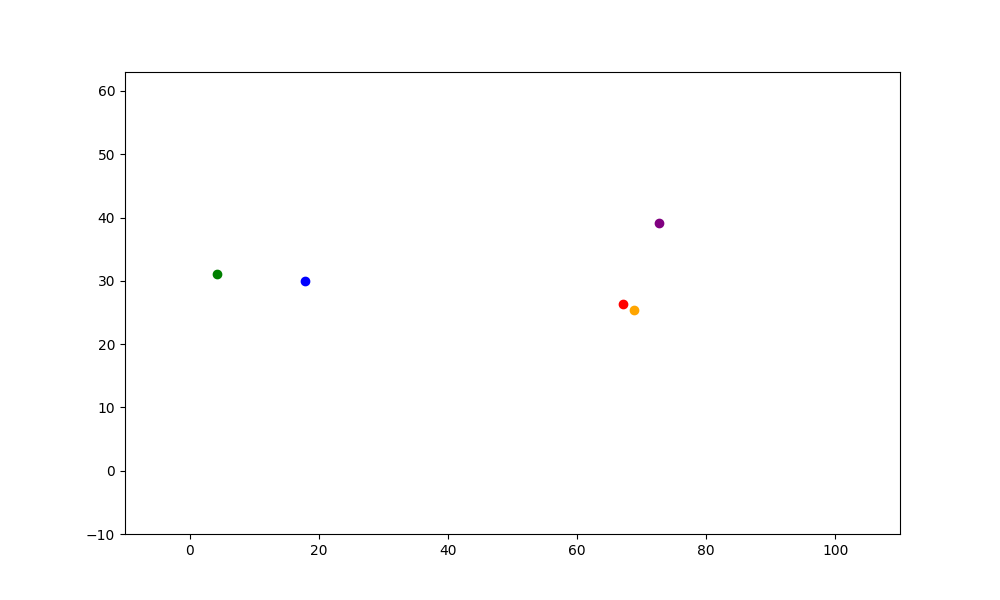

In [250]:
row = 0
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
c = 'blue'
football_x = model_data_df.iloc[row]['x_x'][0]
football_y = model_data_df.iloc[row]['y_x'][0]
ax.scatter(x=football_x, y=football_y, c=c)
c = 'green'
punter_x = model_data_df.iloc[row]['x_x'][1]
punter_y = model_data_df.iloc[row]['y_x'][1]
ax.scatter(x=punter_x, y=punter_y, c=c)
c = 'red'
returner_x = model_data_df.iloc[row]['x_x'][2]
returner_y = model_data_df.iloc[row]['y_x'][2]
ax.scatter(x=returner_x, y=returner_y, c=c)
c = 'purple'
actual_x = model_data_df.iloc[row]['x_y']
actual_y = model_data_df.iloc[row]['y_y']
ax.scatter(x=actual_x, y=actual_y, c=c)
c = 'orange'
predict_x = model_data_df.iloc[row]['prediction'][0]
predict_y = model_data_df.iloc[row]['prediction'][1]
ax.scatter(x=predict_x, y=predict_y, c=c)
plt.show()

In [251]:
# Predict X
model_data_df['prediction'].str[0].describe()

count    4232.000000
mean       60.193566
std        28.671167
min        14.624050
25%        32.233819
50%        68.078752
75%        87.050168
max       104.353973
Name: prediction, dtype: float64

In [252]:
# Actual X
model_data_df['x_y'].describe()

count    4232.000000
mean       60.282573
std        29.301848
min        11.650000
25%        30.852500
50%        64.575000
75%        88.332500
max       109.640000
Name: x_y, dtype: float64

In [253]:
# Predict Y
model_data_df['prediction'].str[1].describe()

count    4232.000000
mean       26.645408
std         6.987181
min         3.107329
25%        21.425824
50%        26.690351
75%        31.789100
max        52.266955
Name: prediction, dtype: float64

In [254]:
# Actual Y
model_data_df['y_y'].describe()

count    4232.000000
mean       26.499031
std        13.341516
min        -8.400000
25%        15.385000
50%        26.430000
75%        37.842500
max        55.650000
Name: y_y, dtype: float64

In [255]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(23 * 2 * 10, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

model = get_model(X.shape[1], y.shape[1])

In [270]:
model.fit(X_train, y_train, verbose=0, epochs=1000)

In [257]:
model_data_df['nn_prediction'] = model.predict(X).tolist()

<IPython.core.display.Javascript object>


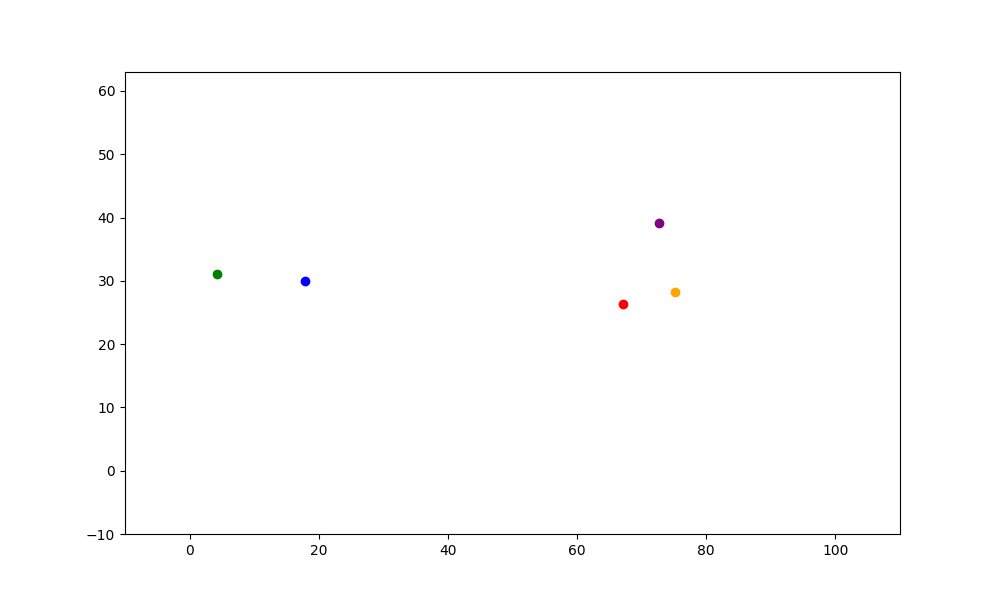

In [269]:
row = 0
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
c = 'blue'
football_x = model_data_df.iloc[row]['x_x'][0]
football_y = model_data_df.iloc[row]['y_x'][0]
ax.scatter(x=football_x, y=football_y, c=c)
c = 'green'
punter_x = model_data_df.iloc[row]['x_x'][1]
punter_y = model_data_df.iloc[row]['y_x'][1]
ax.scatter(x=punter_x, y=punter_y, c=c)
c = 'red'
returner_x = model_data_df.iloc[row]['x_x'][2]
returner_y = model_data_df.iloc[row]['y_x'][2]
ax.scatter(x=returner_x, y=returner_y, c=c)
c = 'purple'
actual_x = model_data_df.iloc[row]['x_y']
actual_y = model_data_df.iloc[row]['y_y']
ax.scatter(x=actual_x, y=actual_y, c=c)
c = 'orange'
predict_x = model_data_df.iloc[row]['nn_prediction'][0]
predict_y = model_data_df.iloc[row]['nn_prediction'][1]
ax.scatter(x=predict_x, y=predict_y, c=c)
plt.show()

In [259]:
model_data_df['linearRegressionAbsoluteError'] = (
    (model_data_df['x_y'] - model_data_df['prediction'].str[0]) ** 2 +
    (model_data_df['y_y'] - model_data_df['prediction'].str[1]) ** 2
) ** 0.5
model_data_df['neuralNetworkAbsoluteError'] = (
    (model_data_df['x_y'] - model_data_df['nn_prediction'].str[0]) ** 2 +
    (model_data_df['y_y'] - model_data_df['nn_prediction'].str[1]) ** 2
) ** 0.5

In [260]:
y_test_predict = reg.predict(X_test)
linearRegressionAbsoluteErrorTest = (
    (y_test[:, 0] - y_test_predict[:, 0]) ** 2 +
    (y_test[:, 1] - y_test_predict[:, 1]) ** 2
) ** 0.5
y_nn_test_predict = model.predict(X_test)
neuralNetworkAbsoluteErrorTest = (
    (y_test[:, 0] - y_nn_test_predict[:, 0]) ** 2 +
    (y_test[:, 1] - y_nn_test_predict[:, 1]) ** 2
) ** 0.5

In [261]:
model_data_df['linearRegressionAbsoluteError'].mean()

11.448729846951057

In [262]:
np.mean(linearRegressionAbsoluteErrorTest, axis=0)

11.512040167633382

In [263]:
model_data_df['neuralNetworkAbsoluteError'].mean()

11.372661844674846

In [264]:
np.mean(neuralNetworkAbsoluteErrorTest, axis=0)

11.753306310869123

In [265]:
reg.score(X_test, y_test)

0.5889695090517568

In [266]:
model.evaluate(X_train, y_train)

106/106 [==============================] - 0s 501us/step - loss: 6.9385


6.938467502593994

In [267]:
model.evaluate(X_test, y_test)

27/27 [==============================] - 0s 569us/step - loss: 7.2242


7.224174499511719

In [268]:
X_train.shape

(3385, 46)